<a href="https://colab.research.google.com/github/gustavo-moretto/WebScrapping_ImoveisCuritiba/blob/main/imoveis_curitiba_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
class database_imoveis():

  def __init__(self, n_paginas):
    self.n_paginas = n_paginas

  def analise_imoveis( self, 
                    comprar_alugar=['aluguel', 'venda'], 
                    tipos_imoveis = ['apartamento_residencial', 'casa_residencial', 'condominio_residencial', 'cobertura_residencial', 'flat_residencial', 'kitnet_residencial', 'sobrado_residencial']):
    
    lista_bairros = ['Alt', 'Alto',  'Bairr', 'Bairro', 'Bo', 'Boa',  'Camp', 'Campo', 'Campin', 'Campina', 'Campo Comprido', 'Campo d', 'Capã', 'Capão',  'Centr',  
                     'Cidad', 'Cidade', 'Crist', 'Cristo',  'Jardi', 'Jardim',  'Nov', 'Novo',  'Prado', 'Prado',  'Sant', 'Santa',  'Siti', 
                     'Sitio', 'São', 'Sã',  'Vil', 'Vila', 'Vist', 'Vista',  'Águ', 'Água Verde']

    import requests
    import pandas as pd
    from time import sleep
    from bs4 import BeautifulSoup

    import seaborn as sns
    import matplotlib.pyplot as plt    

    from google.colab import files
    from datetime import date 

    conjunto_imoveis = {}
    c = 0
    for negocio in comprar_alugar:      
      for pagina in range( self.n_paginas ):
          for tipo_imovel in tipos_imoveis:
            print(f'Coletando dados de {negocio} para {tipo_imovel}.')
            sleep(1)  
            # faz a requisição do site e verifica se esta foi bem-sucedida
            req = requests.get(f"https://www.vivareal.com.br/{negocio}/parana/curitiba/{tipo_imovel}/?pagina={pagina}")

            if req.status_code == 200:
                #print(f'Pag. {pagina}: Requisição bem sucedida!')
                content = req.content
            else:
              print(req.status_code)
              break
              
            # lê o arquivo html com a biblioteca BeautifulSoup
            soup = BeautifulSoup(content, 'html.parser')
              
            # seleciona os dados dos imóveis
            # para isso, encontramos todas as tags <a> com a "class" = "property-card__content-link js-card-title"
            imoveis = soup.find_all('a', attrs={'class':"property-card__content-link js-card-title"})
              
            for imovel in range(len(imoveis)):        
                c += 1
                  
                indice_imovel = c
                # extrai a descrição do imóvel
                #descricao = imoveis[imovel].find("span", attrs={"class":"property-card__title js-cardLink js-card-title"}).text                 

                # extrai o endereço e o bairro do imóvel
                endereco = imoveis[imovel].find("span", attrs={"class":"property-card__address"}).text
                end_completo = endereco

                for elemento in range(len(endereco.split())):
                    if endereco.split()[elemento] == '-':
                        end = endereco.split()[elemento + 1]                  

                        # bairros com nomes compostos -> dessa forma, o nome eh extraido da maneira correta                 
                        if end in lista_bairros:
                          endereco = endereco.split()[elemento + 1] + ' ' + endereco.split()[elemento + 2]
                          # excluir a virgula do final do bairro
                          endereco = endereco[:-1]                    
                        elif end == 'Alto':
                          endereco = endereco.split()[elemento + 1] + ' ' + endereco.split()[elemento + 2] + ' ' + endereco.split()[elemento + 3]
                          # excluir a virgula do final do bairro
                          endereco = endereco[:-1]
                        
                        # caso nao haja o nome da rua, o bairro sera igual a 'PR'
                        # para extrair o bairro, devemos extrair o primeiro elemento da lista
                        elif end == 'PR':
                          endereco = endereco.split()[0][:-1]
                        else:
                          endereco = endereco.split()[elemento + 1]
                          # excluir a virgula do final do bairro
                          endereco = endereco[:-1]
                        break
                # extrai a área do imóvel (m²)
                # como existem imoveis com a area variavel, p. ex. 20-30, criei uma excecao
                # neste caso, a area do imovel sera igual a 0
                # creio que isso traz mais realidade ao dataset tambem
                try:
                  area_m2 = float(imoveis[imovel].find("span", attrs={"class":"property-card__detail-value js-property-card-value property-card__detail-area js-property-card-detail-area"}).text)
                except ValueError:
                  area_m2 = 0

                # extrai os itens do imóvel, como mobília, churrasqueira, academia...
                #try:
                    #itens = imoveis[imovel].find("ul", attrs={"class":"property-card__amenities"}).text.split()
                #except AttributeError:
                    #itens = []
                #try:
                    #if itens[-1] == '...':
                        #itens = itens[:-1]
                  #except IndexError:
                      #pass

                # número de comodos (caso não possua vaga de garagem, por exemplo, será atribuído valor 0)
                comodos = []
                try:
                    for k in imoveis[imovel].find_all("span", attrs={"class":"property-card__detail-value js-property-card-value"}):
                        comodos.append(float(k.text))
                except ValueError:
                    comodos.append(0)
                if len(comodos) == 3:
                  quartos = float(comodos[0])
                  banheiros = float(comodos[1])
                  vagas = float(comodos[2])
                else:
                  quartos = 0
                  banheiros = 0
                  vagas = 0

                # extrai o valor do aluguel
                try: 
                  preco = imoveis[imovel].find("p", attrs={'style':"display: block;"}).text                                                                                         
                  try:          
                    if (negocio == 'aluguel' and len(preco.split()[1]) >= 5):            
                      preco = float(preco.split()[1])      
                      preco = preco * 1000                    
                    elif negocio == 'venda' and len(preco.split()) == 2:
                      preco = float(preco.split()[1])
                      preco = preco * 1000                    
                    elif negocio == 'venda' and len(preco.split()) == 6:
                      preco = float(preco.split()[1])
                      preco = preco * 1000                    
                    elif negocio == 'venda' and len(preco.split()) == 5:
                      preco = float(preco.split()[4])
                      preco = preco * 1000                    
                    else:
                      preco = preco.split()[1]
                      if negocio == 'aluguel' and len(preco) == 3:                        
                        preco = preco.replace('.', '')
                        preco = float(preco)
                      else:
                        preco = float(preco)                    
                        preco = preco * 1000                                                      
                  except ValueError:
                    preco = imoveis[imovel].find("p", attrs={'style':"display: block;"}).text
                    preco = preco.replace('.', '')            
                    preco = float(preco.split()[1])
                except AttributeError:                                
                  preco = 0                     

                # extrai o valor do condominio (se não existir, será 0)
                # no laco, caso o valor do condominio seja superior a 999.99 reais, sera multiplicado por 1000
                try:
                    condominio = imoveis[imovel].find("strong", attrs={'class':"js-condo-price"}).text
                    if len(condominio.split()[1]) == 3:
                      condominio = float(condominio.split()[1])
                    else:
                      condominio = float(condominio.split()[1])*1000             
                except AttributeError or ValueError:
                    condominio = 0

                conjunto_imoveis[c] = (negocio, tipo_imovel, indice_imovel, end_completo, endereco, area_m2, quartos, banheiros, vagas, preco, condominio)

    self.df = pd.DataFrame.from_dict(conjunto_imoveis)
    self.df = self.df.T
    self.df = self.df.rename(columns={ 0:'comprar_alugar', 1:'tipo_imovel', 2:'indice', 3:'end_completo', 4:'bairro', 5:'area_m2', 6:'quartos', 7:'banheiros', 8:'vagas_garagem', 9:'preco', 10:'condominio'})
    
    colunas_float = ['area_m2', 'quartos', 'banheiros', 'vagas_garagem', 'preco', 'condominio']
    for coluna in colunas_float: 
      self.df[coluna] = self.df[coluna].astype( float )
        
    print(f'Base de dados criada: {len(self.df)} imoveis cadastrados.')

    # download da base de dados
    download_basedados = str(input('Deseja fazer o download da base de dados [s/n]: '))
    if download_basedados.upper() == 'S':
      today = date.today()
      print(f'Download do arquivo df_imoveis_{today}.csv')
      self.df.to_csv(f'df_imoveis_{today}.csv')
      files.download(f'df_imoveis_{today}.csv')
    else:
      print('Base de dados nao foi baixada.')

    return self.df

In [2]:
database = database_imoveis(1)
df = database.analise_imoveis()
df.head()

Coletando dados de aluguel para apartamento_residencial.
Coletando dados de aluguel para casa_residencial.
Coletando dados de aluguel para condominio_residencial.
Coletando dados de aluguel para cobertura_residencial.
Coletando dados de aluguel para flat_residencial.
Coletando dados de aluguel para kitnet_residencial.
Coletando dados de aluguel para sobrado_residencial.
Coletando dados de venda para apartamento_residencial.
Coletando dados de venda para casa_residencial.
Coletando dados de venda para condominio_residencial.
Coletando dados de venda para cobertura_residencial.
Coletando dados de venda para flat_residencial.
Coletando dados de venda para kitnet_residencial.
Coletando dados de venda para sobrado_residencial.
Base de dados criada: 490 imoveis cadastrados.
Deseja fazer o download da base de dados [s/n]: n
Base de dados nao foi baixada.


,comprar_alugar,tipo_imovel,indice,end_completo,bairro,area_m2,quartos,banheiros,vagas_garagem,preco,condominio
1,aluguel,apartamento_residencial,1,"Rua Manoel Eufrásio, 1231 - Juvevê, Curitiba - PR",Juvevê,40.0,1.0,1.0,1.0,2600.0,550.0
2,aluguel,apartamento_residencial,2,"Rua Tijucas do Sul, 2680 - Sitio Cercado, Curi...",Sitio Cercado,60.0,2.0,1.0,1.0,1100.0,300.0
3,aluguel,apartamento_residencial,3,"Rua Francisco Rocha, 1777 - Bigorrilho, Curiti...",Bigorrilho,155.0,4.0,4.0,2.0,2500.0,980.0
4,aluguel,apartamento_residencial,4,"Rua Silveira Peixoto, 613 - Água Verde, Curiti...",Água Verde,68.0,2.0,1.0,0.0,1300.0,0.0
5,aluguel,apartamento_residencial,5,"Rua Alferes Ângelo Sampaio - Bigorrilho, Curit...",Bigorrilho,82.0,3.0,2.0,1.0,6000.0,360.0


# Imports

In [3]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 490 entries, 1 to 490
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   comprar_alugar  490 non-null    object 
 1   tipo_imovel     490 non-null    object 
 2   indice          490 non-null    object 
 3   end_completo    490 non-null    object 
 4   bairro          490 non-null    object 
 5   area_m2         490 non-null    float64
 6   quartos         490 non-null    float64
 7   banheiros       490 non-null    float64
 8   vagas_garagem   490 non-null    float64
 9   preco           490 non-null    float64
 10  condominio      490 non-null    float64
dtypes: float64(6), object(5)
memory usage: 45.9+ KB


In [5]:
# criarei uma coluna de vendas e uma coluna de aluguel que receberao os valores 0 caso a afirmativa seja falsa
# e recebera 1 caso a afirmativa seja verdadeira
# estas colunas ajudarao na analise dos dados
df['venda'] = df['comprar_alugar'].apply( lambda x: 1 if x == 'venda' else 0)
df['aluguel'] = df['comprar_alugar'].apply( lambda x: 1 if x == 'aluguel' else 0)

df.head()

,comprar_alugar,tipo_imovel,indice,end_completo,bairro,area_m2,quartos,banheiros,vagas_garagem,preco,condominio,venda,aluguel
1,aluguel,apartamento_residencial,1,"Rua Manoel Eufrásio, 1231 - Juvevê, Curitiba - PR",Juvevê,40.00000,1.00000,1.00000,1.00000,2600.00000,550.00000,0,1
2,aluguel,apartamento_residencial,2,"Rua Tijucas do Sul, 2680 - Sitio Cercado, Curi...",Sitio Cercado,60.00000,2.00000,1.00000,1.00000,1100.00000,300.00000,0,1
3,aluguel,apartamento_residencial,3,"Rua Francisco Rocha, 1777 - Bigorrilho, Curiti...",Bigorrilho,155.00000,4.00000,4.00000,2.00000,2500.00000,980.00000,0,1
4,aluguel,apartamento_residencial,4,"Rua Silveira Peixoto, 613 - Água Verde, Curiti...",Água Verde,68.00000,2.00000,1.00000,0.00000,1300.00000,0.00000,0,1
5,aluguel,apartamento_residencial,5,"Rua Alferes Ângelo Sampaio - Bigorrilho, Curit...",Bigorrilho,82.00000,3.00000,2.00000,1.00000,6000.00000,360.00000,0,1


# Analise Descritiva de Dados

In [6]:
df.describe(include='all')

,comprar_alugar,tipo_imovel,indice,end_completo,bairro,area_m2,quartos,banheiros,vagas_garagem,preco,condominio,venda,aluguel
count,490,490,490.00000,490,490,490.00000,490.00000,490.00000,490.00000,490.00000,490.00000,490.00000,490.00000
unique,2,7,490.00000,421,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,venda,apartamento_residencial,1.00000,"Centro, Curitiba - PR",Centro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,252,72,1.00000,4,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,141.31837,2.50408,2.46327,1.82041,455875.29796,1607.34898,0.51429,0.48571
std,NaN,NaN,NaN,NaN,NaN,145.21670,1.23223,1.52942,1.66290,871989.14632,9383.14013,0.50031,0.50031
min,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,NaN,NaN,NaN,NaN,NaN,40.25000,1.00000,1.00000,1.00000,2825.00000,0.00000,0.00000,0.00000
50%,NaN,NaN,NaN,NaN,NaN,108.00000,3.00000,2.00000,2.00000,134000.00000,227.50000,1.00000,0.00000
75%,NaN,NaN,NaN,NaN,NaN,191.00000,3.00000,3.00000,2.00000,598750.00000,600.00000,1.00000,1.00000


## EDA dividida por tipo de negocio -> aluguel

In [7]:
# EDA dividida por tipo de negocio -> aluguel
df[df['comprar_alugar'] == 'aluguel'].describe()

,area_m2,quartos,banheiros,vagas_garagem,preco,condominio,venda,aluguel
count,238.00000,238.00000,238.00000,238.00000,238.00000,238.00000,238.00000,238.00000
mean,142.28571,2.51681,2.30672,1.79412,14874.67647,2276.15546,0.00000,1.00000
std,147.30136,1.25861,1.43878,1.60289,94484.88189,10562.53998,0.00000,0.00000
min,15.00000,0.00000,0.00000,0.00000,450.00000,0.00000,0.00000,1.00000
25%,45.00000,1.00000,1.00000,1.00000,1500.00000,0.00000,0.00000,1.00000
50%,99.50000,3.00000,2.00000,2.00000,2725.00000,300.00000,0.00000,1.00000
75%,185.00000,3.00000,3.00000,2.00000,4500.00000,717.50000,0.00000,1.00000
max,1440.00000,8.00000,7.00000,8.00000,970000.00000,85000.00000,0.00000,1.00000


A media dos alugueis e de mais de R$ 200.000,00, o que sabemos que e impossivel.
Podemos perceber uma diferenca muito grande da mediana com a media e ate mesmo do terceiro quartil em relacao a media.

Plotaremos um boxplot para nos auxiliar a enxergamos a distribuicao do valor dos alugueis e estabelecermos qual atitude devemos tomar.

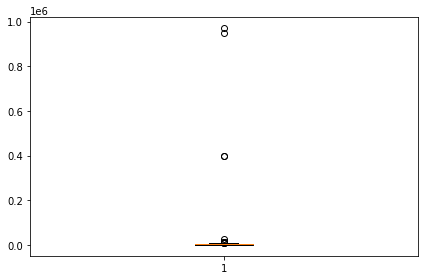

In [9]:
df_aluguel = df[df['comprar_alugar'] == 'aluguel']
plt.boxplot( x=df_aluguel['preco'] );
plt.tight_layout()

Temos muitos outliers neste grafico.
Talvez o melhor a fazer seja excluidos da base de dados.
Para isso, irei ver quantos registros estao acima do limite superior do nosso boxplot, utilizando a formula:
Limite_Superior = Q3 + 1.5 * (Q3 - Q1)

In [10]:
q1 = 1800
q3 = 6500

lim_sup = q3 + 1.5*(q3 - q1)

display(df_aluguel[df_aluguel['preco'] > lim_sup])

,comprar_alugar,tipo_imovel,indice,end_completo,bairro,area_m2,quartos,banheiros,vagas_garagem,preco,condominio,venda,aluguel
50,aluguel,casa_residencial,50,"Rua Júlia Huga Maria Negrello, 291 - Centro, C...",Centro,191.00000,3.00000,3.00000,2.00000,970000.00000,470.00000,0,1
56,aluguel,casa_residencial,56,"Rua Hermes Fontes, 1010 - Batel, Curitiba - PR",Batel,500.00000,4.00000,5.00000,6.00000,15000.00000,0.00000,0,1
59,aluguel,casa_residencial,59,"Rua Guaianazes, 550 - Centro, Curitiba - PR",Centro,250.00000,3.00000,4.00000,4.00000,950000.00000,0.00000,0,1
87,aluguel,condominio_residencial,87,"Alameda das Buganvílias - Mossunguê, Curitiba ...",Mossunguê,700.00000,5.00000,7.00000,3.00000,27000.00000,670.00000,0,1
154,aluguel,flat_residencial,154,"Rua Constantino Marochi, 1342 - Alto da Glória...",Alto da Glória,27.00000,1.00000,1.00000,0.00000,400000.00000,0.00000,0,1
155,aluguel,flat_residencial,155,"Rua Constantino Marochi, 1342 - Alto da Glória...",Alto da Glória,27.00000,1.00000,1.00000,0.00000,400000.00000,0.00000,0,1
234,aluguel,sobrado_residencial,234,Rua Padre Francisco João Azevedo - Jardim Botâ...,Jardi,1440.00000,5.00000,7.00000,6.00000,15000.00000,0.00000,0,1


Como podemos observar, ha imoveis com valores extremamente altos! 
Iremos manter os imoveis com aluguel maximo de R$ 27.000,00.

In [12]:
df_aluguel = df_aluguel[df_aluguel['preco'] < 27001]
df_aluguel.head()

,comprar_alugar,tipo_imovel,indice,end_completo,bairro,area_m2,quartos,banheiros,vagas_garagem,preco,condominio,venda,aluguel
1,aluguel,apartamento_residencial,1,"Rua Manoel Eufrásio, 1231 - Juvevê, Curitiba - PR",Juvevê,40.00000,1.00000,1.00000,1.00000,2600.00000,550.00000,0,1
2,aluguel,apartamento_residencial,2,"Rua Tijucas do Sul, 2680 - Sitio Cercado, Curi...",Sitio Cercado,60.00000,2.00000,1.00000,1.00000,1100.00000,300.00000,0,1
3,aluguel,apartamento_residencial,3,"Rua Francisco Rocha, 1777 - Bigorrilho, Curiti...",Bigorrilho,155.00000,4.00000,4.00000,2.00000,2500.00000,980.00000,0,1
4,aluguel,apartamento_residencial,4,"Rua Silveira Peixoto, 613 - Água Verde, Curiti...",Água Verde,68.00000,2.00000,1.00000,0.00000,1300.00000,0.00000,0,1
5,aluguel,apartamento_residencial,5,"Rua Alferes Ângelo Sampaio - Bigorrilho, Curit...",Bigorrilho,82.00000,3.00000,2.00000,1.00000,6000.00000,360.00000,0,1


In [13]:
df_aluguel.describe()

,area_m2,quartos,banheiros,vagas_garagem,preco,condominio,venda,aluguel
count,234.00000,234.00000,234.00000,234.00000,234.00000,234.00000,234.00000,234.00000
mean,142.60256,2.52564,2.30769,1.79915,3505.01282,2313.05556,0.00000,1.00000
std,147.97303,1.26074,1.44104,1.60145,3056.21860,10648.96678,0.00000,0.00000
min,15.00000,0.00000,0.00000,0.00000,450.00000,0.00000,0.00000,1.00000
25%,45.00000,1.00000,1.00000,1.00000,1500.00000,0.00000,0.00000,1.00000
50%,99.50000,3.00000,2.00000,2.00000,2600.00000,300.00000,0.00000,1.00000
75%,184.75000,3.00000,3.00000,2.00000,4475.00000,745.00000,0.00000,1.00000
max,1440.00000,8.00000,7.00000,8.00000,27000.00000,85000.00000,0.00000,1.00000


Agora nosso dataset possui dados mais coerentes com a realidade.
Iremos utiliza-lo para visualizarmos como o preco dos imoveis varia de acordo com suas caracteristicas.

In [23]:
lista_bairros = df['bairro'].drop_duplicates().to_list()

In [ ]:
lista_bairros = ['Alt', 'Alto',  'Bairr', 'Bairro', 'Bo', 'Boa',  'Camp', 'Campo', 'Campin', 'Campina', 'Campo Comprido', 'Campo d', 'Capã', 'Capão',  'Centr',  'Cidad', 'Cidade', 'Crist', 'Cristo',  'Jardi', 'Jardim',  'Nov', 'Novo',  'Prado', 'Prado',  'Sant', 'Santa',  'Siti', 'Sitio', 'São', 'Sã',  'Vil', 'Vila', 'Vist', 'Vista',  'Águ', 'Água Verde']

In [28]:
['Alt', 'Alto',  'Bairr', 'Bairro', 'Bo', 'Boa',  'Camp', 'Campo', 'Campin', 'Campina', 'Campo Comprido', 'Campo d', 'Capã', 'Capão',  'Centr',  'Cidad', 'Cidade', 'Crist', 'Cristo',  'Jardi', 'Jardim',  'Nov', 'Novo',  'Prado', 'Prado',  'Sant', 'Santa',  'Siti', 'Sitio', 'São', 'Sã',  'Vil', 'Vila', 'Vist', 'Vista',  'Águ', 'Água Verde']

['Abranches',
 'Ahú',
 'Alt',
 'Alto Boqueirão, Curitib',
 'Alto da Glória',
 'Alto da Ru',
 'Atuba',
 'Augusta',
 'Bacacheri',
 'Bairr',
 'Barigui',
 'Barreirinha',
 'Batel',
 'Bigorrilho',
 'Bo',
 'Boa Vista',
 'Boqueirão',
 'Butiatuvinha',
 'Cabral',
 'Cachoeira',
 'Caiuá',
 'Cajuru',
 'Camp',
 'Campin',
 'Campo Comprido',
 'Campo d',
 'Capã',
 'Capão Raso',
 'Cascatinha',
 'Centr',
 'Centro',
 'Champagnat',
 'Cidad',
 'Cidade Industrial',
 'Crist',
 'Cristo Rei',
 'Ecoville',
 'Fanny',
 'Fazendinha',
 'Guabirotuba',
 'Hauer',
 'Jardi',
 'Juvevê',
 'Lindóia',
 'Mercês',
 'Mossunguê',
 'Nov',
 'Orleans',
 'Parolin',
 'Pilarzinho',
 'Pinheirinho',
 'Portão',
 'Prad',
 'Rebouças',
 'Sant',
 'Santa Cândida',
 'Santa Felicidade',
 'Santa Quitéria',
 'Seminário',
 'Siti',
 'Sitio Cercado',
 'Sã',
 'Tarumã',
 'Tatuquara',
 'Tingui',
 'Uberaba',
 'Umbara',
 'Vil',
 'Vist',
 'Vista Alegre',
 'Xaxim',
 'Águ',
 'Água Verde']

In [14]:
df_aluguel.groupby('bairro').agg({'preco': ['mean', 'min', 'max', 'std']})

preco                                   
                               mean         min         max        std
bairro                                                                
Abranches                8900.00000  8900.00000  8900.00000        NaN
Ahú                     10000.00000 10000.00000 10000.00000        NaN
Alt                      4596.66667  1890.00000  7500.00000 2810.16607
Alto Boqueirão, Curitib   800.00000   800.00000   800.00000        NaN
Alto da Glória           2030.00000  1500.00000  2600.00000  551.08983
...                             ...         ...         ...        ...
Vist                     5000.00000  5000.00000  5000.00000        NaN
Vista Alegre             2933.33333  1800.00000  5000.00000 1792.57729
Xaxim                    1616.66667   650.00000  2400.00000  889.28810
Águ                      9750.00000  7500.00000 12000.00000 3181.98052
Água Verde               4145.45455  1300.00000  8500.00000 1668.00098

[65 rows x 4 columns]

## EDA dividida por tipo de negocio -> VENDA

In [ ]:
df_venda = df[df['comprar_alugar'] == 'venda']

In [ ]:
# EDA dividida por tipo de negocio -> venda
df_venda.describe()

,area_m2,quartos,banheiros,vagas_garagem,preco,condominio,venda,aluguel
count,252.00000,252.00000,252.00000,252.00000,252.00000,252.00000,252.00000,252.00000
mean,140.74603,2.49206,2.61905,1.85317,879935.80556,976.03571,1.00000,0.00000
std,143.67313,1.20917,1.60605,1.72579,1060441.82715,8084.38150,0.00000,0.00000
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
25%,37.50000,1.00000,1.00000,1.00000,274989.75000,0.00000,1.00000,0.00000
50%,114.50000,3.00000,2.00000,2.00000,590000.00000,0.00000,1.00000,0.00000
75%,199.25000,3.00000,3.25000,2.25000,992685.75000,550.00000,1.00000,0.00000
max,1150.00000,8.00000,8.00000,15.00000,8200000.00000,125000.00000,1.00000,0.00000


In [ ]:
q1 = 274989.75
q3 = 992685.75

lim_inf = q1 - 1.5*(q3 - q1)

display(df_venda[df_venda['preco'] > lim_inf])

,comprar_alugar,tipo_imovel,indice,end_completo,bairro,area_m2,quartos,banheiros,vagas_garagem,preco,condominio,venda,aluguel
239,venda,apartamento_residencial,239,"Rua Rezala Simão, 650 - Santa Quitéria, Curiti...",Santa Quitéria,57.00000,3.00000,1.00000,1.00000,274999.00000,460.00000,1,0
240,venda,apartamento_residencial,240,"Avenida Visconde de Guarapuava, 3070 - Centro,...",Centro,0.00000,1.00000,1.00000,0.00000,171000.00000,0.00000,1,0
241,venda,apartamento_residencial,241,"Avenida Nossa Senhora da Luz, 160 - Bacacheri,...",Bacacheri,87.00000,3.00000,2.00000,1.00000,540000.00000,517.00000,1,0
242,venda,apartamento_residencial,242,"Rua Chichorro Júnior, 371 - Cabral, Curitiba - PR",Cabral,85.00000,2.00000,2.00000,2.00000,750000.00000,600.00000,1,0
243,venda,apartamento_residencial,243,"Rua Antônio Rodrigues, 120 - Seminário, Curiti...",Seminário,119.00000,3.00000,3.00000,2.00000,950000.00000,650.00000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,venda,sobrado_residencial,486,"Rua dos Bem-te-vis - Novo Mundo, Curitiba - PR",Nov,202.00000,5.00000,5.00000,5.00000,950000.00000,0.00000,1,0
487,venda,sobrado_residencial,487,"Rua João Antônio Xavier, 39 - Água Verde, Curi...",Água Verde,198.00000,3.00000,5.00000,2.00000,1090000.00000,100.00000,1,0
488,venda,sobrado_residencial,488,"Rua Tenente Antônio Pupo, 122 - Xaxim, Curitib...",Xaxim,85.00000,3.00000,2.00000,2.00000,380000.00000,150.00000,1,0
489,venda,sobrado_residencial,489,"Rua Padre Dehon, 1345 - Hauer, Curitiba - PR",Hauer,107.00000,3.00000,3.00000,2.00000,590000.00000,0.00000,1,0


In [ ]:
df_venda[df_venda['preco'] < 150000]

,comprar_alugar,tipo_imovel,indice,end_completo,bairro,area_m2,quartos,banheiros,vagas_garagem,preco,condominio,venda,aluguel
248,venda,apartamento_residencial,248,"Rua Maria de Lourdes Kudri, 127 - Barreirinha,...",Barreirinha,44.00000,2.00000,1.00000,0.00000,140000.00000,312.00000,1,0
266,venda,apartamento_residencial,266,"Rua Ângelo Tozim, 1220 - Campo de Santana, Cur...",Campo d,41.00000,2.00000,1.00000,1.00000,125000.00000,273.00000,1,0
307,venda,casa_residencial,307,"Rua Raposo Tavares - Pilarzinho, Curitiba - PR",Pilarzinho,216.00000,3.00000,3.00000,3.00000,3200.00000,0.00000,1,0
312,venda,condominio_residencial,312,"Rua Nicolau José Gravina, 911 - Cascatinha, Cu...",Cascatinha,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1,0
367,venda,cobertura_residencial,367,"Hauer, Curitiba - PR",Hauer,99.00000,3.00000,2.00000,1.00000,2500.00000,345.00000,1,0
411,venda,flat_residencial,411,"Rua XV de Novembro, 2051 - Alto da Rua XV, Cur...",Alto da Ru,25.00000,1.00000,1.00000,0.00000,115000.00000,0.00000,1,0
419,venda,kitnet_residencial,419,"Rua Alferes Poli, 276 - Centro, Curitiba - PR",Centro,17.00000,1.00000,1.00000,0.00000,124990.00000,370.00000,1,0
426,venda,kitnet_residencial,426,"Rua Alferes Poli, 304 - Centro, Curitiba - PR",Centro,20.00000,1.00000,1.00000,0.00000,135000.00000,313.00000,1,0
427,venda,kitnet_residencial,427,"Rua Alferes Poli, 459 - Centro, Curitiba - PR",Centro,26.00000,1.00000,1.00000,0.00000,146000.00000,430.00000,1,0
430,venda,kitnet_residencial,430,"Rua Luiz Carlos Muggiati - Alto Boqueirão, Cur...","Alto Boqueirão, Curitib",25.00000,1.00000,1.00000,1.00000,119000.00000,199.00000,1,0


In [ ]:
# Imoveis p/ vender vs Imoveis p/ alugar

print('Imoveis a Venda vs Imoveis p/ Alugar')
df[['comprar_alugar', 'tipo_imovel']].groupby('comprar_alugar').count()

In [ ]:
# Imoveis por tipo: Aluguel vs Venda

print('Imoveis por tipo: Aluguel vs Venda')
df[['tipo_imovel', 'venda', 'aluguel']].groupby('tipo_imovel').sum()

In [ ]:
df[df['comprar_alugar'] == 'venda'].groupby('tipo_imovel').agg({'preco': ['mean', 'min', 'max', 'std']})